In [106]:
import os
import pandas as pd
from IPython.display import IFrame
import folium
import seaborn as sns
import glob
import networkx as nx
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# reading and formatting the data

In [2]:
loc='/Users/wentingjiang/Desktop/mda_kul_local/'

In [3]:
def read_noise_data(folder_path='export_40/'):
   # folder_path = 'export_40/'  # Replace with the path to your folder
    all_files = glob.glob(folder_path + "/*.csv")

    dfs = []
    for filename in all_files:
        data = pd.read_csv(filename, index_col=None, header=0, sep=';')

        data.loc[data['description'] == 'MP08bis - Vrijthof', 'description'] = 'MP 08: bis - Vrijthof'
        #data.loc[data['description'] == 'Naamsestraat 35  Maxim', 'description'] = 'MP 01: Naamsestraat 35 Maxim'

       #location_name = filename.split('.')[0].split('/')[-1].split('_')[-1]
       # print(location_name)
       # data['location']=location_name
        dfs.append(data)

    df_percentiled = pd.concat(dfs, axis=0, ignore_index=True)
    return df_percentiled

## Noise percentiled

In [6]:
# this data was not used for now
df_percentiled= read_noise_data(loc+'export_40/')

In [7]:
df_percentiled.head()

,#object_id,description,result_timestamp,laf005_per_hour,laf005_per_hour_unit,laf01_per_hour,laf01_per_hour_unit,laf05_per_hour,laf05_per_hour_unit,laf10_per_hour,...,laf90_per_hour,laf90_per_hour_unit,laf95_per_hour,laf95_per_hour_unit,laf98_per_hour,laf98_per_hour_unit,laf99_per_hour,laf99_per_hour_unit,laf995_per_hour,laf995_per_hour_unit
0,255439,MP 01: Naamsestraat 35 Maxim,07/03/2022 13:00:00.000,65.4,dB(A),64.0,dB(A),60.5,dB(A),58.0,...,47.4,dB(A),46.4,dB(A),45.2,dB(A),44.8,dB(A),44.0,dB(A)
1,255439,MP 01: Naamsestraat 35 Maxim,07/03/2022 14:00:00.000,72.2,dB(A),70.8,dB(A),65.8,dB(A),62.6,...,45.2,dB(A),43.9,dB(A),42.4,dB(A),41.4,dB(A),40.4,dB(A)
2,255439,MP 01: Naamsestraat 35 Maxim,07/03/2022 15:00:00.000,74.5,dB(A),72.2,dB(A),66.0,dB(A),63.5,...,48.6,dB(A),47.3,dB(A),45.8,dB(A),45.2,dB(A),44.5,dB(A)
3,255439,MP 01: Naamsestraat 35 Maxim,07/03/2022 16:00:00.000,72.0,dB(A),70.3,dB(A),65.0,dB(A),62.0,...,45.4,dB(A),43.8,dB(A),42.4,dB(A),41.5,dB(A),40.9,dB(A)
4,255439,MP 01: Naamsestraat 35 Maxim,07/03/2022 17:00:00.000,72.6,dB(A),71.2,dB(A),66.6,dB(A),63.6,...,45.5,dB(A),43.8,dB(A),42.3,dB(A),41.4,dB(A),40.7,dB(A)


In [8]:
def create_location_name_dict(df_percentiled):

    pair_dict = {p.split(': ')[0]: p.split(': ')[1] for p in df_percentiled['description']}
    return pair_dict

In [9]:
location_dict=create_location_name_dict(df_percentiled)
location_dict

{'MP 01': 'Naamsestraat 35  Maxim',
 'MP 03': 'Naamsestraat 62 Taste',
 'MP 05': 'Calvariekapel KU Leuven',
 'MP 06': 'Parkstraat 2 La Filosovia',
 'MP 08': 'bis - Vrijthof',
 'MP 02': 'Naamsestraat 57 Xior',
 'MP 07': 'Naamsestraat 81',
 'MP 04': 'His & Hears'}

In [10]:
def truncate_time_to_min(df):
    df['timestamp'] = df['result_timestamp'].str[:-7]
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
    
    return df.drop('result_timestamp', axis=1)

In [11]:
df_percentiled2 = truncate_time_to_min(df_percentiled)

In [12]:
def generate_noise_network_percentiled(df):
    """
    function unfinished
    """
    
# Create a graph with nodes representing monitoring stations
    G = nx.Graph()
    for station in df['description'].unique():
        G.add_node(station, name=station)

    # Add edges between nodes based on noise level correlations
    for station1 in df['description'].unique():
        for station2 in df['description'].unique():
            if station1 != station2:
                noise1 = df[df['description'] == station1]#['laf005_per_hour'].values
                noise2 = df[df['description'] == station2]#['laf005_per_hour'].values
                result = pd.merge(noise1, noise2, on='result_timestamp', how='inner')

                corr = np.corrcoef(result['laf005_per_hour_x'], result['laf005_per_hour_y'])[0,1]
                if corr > 0.8:
                    G.add_edge(station1, station2, weight=corr)

    # Use community detection algorithm to identify clusters
    communities = nx.community.greedy_modularity_communities(G)

    # Visualize the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos=pos, node_color=[communities.index(c) for n,c in nx.get_node_attributes(G,'community').items()], cmap='tab20')
    
    #generate_noise_network_percentiled(df_percentiled2)

## Noise level

In [13]:
loc+'export_42/**/'

'/Users/wentingjiang/Desktop/mda_kul_local/export_42/**/'

In [ ]:
# read noise data for a certain month

In [26]:
# read only 1 month data for now, August

df_noise_level = read_noise_data(loc+'export_42/Aug/')

# change to loc+'export_42/**/' for reading all months, but the kernel will crash

In [27]:
df_noise_level.head()

,#object_id,description,result_timestamp,lamax,lamax_unit,laeq,laeq_unit,lceq,lceq_unit,lcpeak,lcpeak_unit
0,255441,MP 03: Naamsestraat 62 Taste,01/08/2022 00:00:00.690,53.3,dB(A),52.8,dB(A),62.67,dB(C),73.21,dB(C)
1,255441,MP 03: Naamsestraat 62 Taste,01/08/2022 00:00:01.690,55.6,dB(A),54.5,dB(A),67.38,dB(C),78.73,dB(C)
2,255441,MP 03: Naamsestraat 62 Taste,01/08/2022 00:00:02.690,56.3,dB(A),55.6,dB(A),65.78,dB(C),78.17,dB(C)
3,255441,MP 03: Naamsestraat 62 Taste,01/08/2022 00:00:03.690,56.8,dB(A),56.1,dB(A),65.60,dB(C),76.03,dB(C)
4,255441,MP 03: Naamsestraat 62 Taste,01/08/2022 00:00:04.690,58.8,dB(A),58.4,dB(A),66.71,dB(C),78.19,dB(C)


In [47]:
# no missing values
# there are some missing values in certain month, but not in all months
def print_na_percent(df):
    print(df.isna().sum()/df.shape[0])
    
print_na_percent(df_noise_level)

#object_id          0.0
description         0.0
result_timestamp    0.0
lamax               0.0
lamax_unit          0.0
laeq                0.0
laeq_unit           0.0
lceq                0.0
lceq_unit           0.0
lcpeak              0.0
lcpeak_unit         0.0
timestamp           0.0
dtype: float64


In [29]:
# the number of unique locations for the noise level
len(df_noise_level['description'].unique())

7

In [30]:
# def get_average_noise_level_per_min(df_noise_level):
    
#     # reduce to min precision 
#     df_noise_level['timestamp'] = df_noise_level['result_timestamp'].str[:-7]
    
#     df_noise_level_min=df_noise_level.groupby(['description', 'timestamp'])['lamax'].mean().reset_index()
    
#     print(df_noise_level_min.groupby('description').count())
    
#     df_noise_level_min_wide = pd.pivot_table(df_noise_level_min, values='lamax', index='timestamp', columns='description')

#     # some locations have more timestamps, make them equal length of time stamp
#   #  df_noise_level_min_clean = df_noise_level_min_wide.reset_index().dropna()
#     df_noise_level_min_clean = df_noise_level_min_wide.reset_index()
    
#     # locations have high corr for the noise level
#     # print(df_noise_level_min_clean.corr())
    
#     # make the precision to minute level (double check later if this is sufficient)
#     df_noise_level_min_clean['timestamp'] = pd.to_datetime(df_noise_level_min_clean['timestamp'], errors='coerce')
#     df_noise_level_min_clean['timestamp'] = df_noise_level_min_clean['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
    
#     return df_noise_level_min_clean

In [31]:
def get_max_noise_level_per_min(df_noise_level):
    
    '''
    new function, use max instead of mean
    '''
    
    # reduce to min precision 
    df_noise_level['timestamp'] = df_noise_level['result_timestamp'].str[:-7]
    
    df_noise_level_min=df_noise_level.groupby(['description', 'timestamp'])['lamax'].max().reset_index()
    
    print(df_noise_level_min.groupby('description').count())
    
    df_noise_level_min_wide = pd.pivot_table(df_noise_level_min, values='lamax', index='timestamp', columns='description')

    # some locations have more timestamps, make them equal length of time stamp
  #  df_noise_level_min_clean = df_noise_level_min_wide.reset_index().dropna()
    df_noise_level_min_clean = df_noise_level_min_wide.reset_index()
    
    # locations have high corr for the noise level
    # print(df_noise_level_min_clean.corr())
    
    # make the precision to minute level (double check later if this is sufficient)
    df_noise_level_min_clean['timestamp'] = pd.to_datetime(df_noise_level_min_clean['timestamp'], errors='coerce')
    df_noise_level_min_clean['timestamp'] = df_noise_level_min_clean['timestamp'].dt.strftime('%Y-%m-%d %H:%M')
    
    return df_noise_level_min_clean

In [32]:
df_noise_agg=get_max_noise_level_per_min(df_noise_level)

                                  timestamp  lamax
description                                       
MP 01: Naamsestraat 35  Maxim         44640  44640
MP 02: Naamsestraat 57 Xior           44640  44640
MP 03: Naamsestraat 62 Taste          44640  44640
MP 05: Calvariekapel KU Leuven        44640  44640
MP 06: Parkstraat 2 La Filosovia      44640  44640
MP 07: Naamsestraat 81                44574  44574
MP 08: bis - Vrijthof                 44640  44640


In [33]:
df_noise_agg.head()

description,timestamp,MP 01: Naamsestraat 35 Maxim,MP 02: Naamsestraat 57 Xior,MP 03: Naamsestraat 62 Taste,MP 05: Calvariekapel KU Leuven,MP 06: Parkstraat 2 La Filosovia,MP 07: Naamsestraat 81,MP 08: bis - Vrijthof
0,2022-01-08 00:00,73.5,72.0,68.0,74.4,70.8,71.0,51.4
1,2022-01-08 00:01,55.9,56.4,57.6,62.1,55.5,61.4,50.5
2,2022-01-08 00:02,69.7,72.0,65.8,67.3,64.5,64.6,54.0
3,2022-01-08 00:03,65.4,57.7,62.2,69.4,66.5,66.3,50.7
4,2022-01-08 00:04,66.0,72.8,74.2,66.1,59.4,53.9,51.6


In [36]:
df_noise_agg.shape

(44640, 8)

In [34]:
#df_noise_agg.to_csv('max_noise_per_minute_per_location.csv')

In [40]:
# still need to remove NaNs
# this means that for each timestamp, not all locations have the noise level for that time stamp
df_noise_agg.isna().sum()

description
timestamp                           27360
MP 01: Naamsestraat 35  Maxim           0
MP 02: Naamsestraat 57 Xior             0
MP 03: Naamsestraat 62 Taste            0
MP 05: Calvariekapel KU Leuven          0
MP 06: Parkstraat 2 La Filosovia        0
MP 07: Naamsestraat 81                 66
MP 08: bis - Vrijthof                   0
dtype: int64

In [41]:
df_noise_agg_no_nan = df_noise_agg[~df_noise_agg['timestamp'].isna()]
df_noise_agg_no_nan.shape

(17280, 8)

## Noise events

In [42]:
df_noise_events = read_noise_data(loc+'export_41/')

In [43]:
df_noise_events2 =truncate_time_to_min(df_noise_events)

In [44]:
df_noise_events2.head()

,#object_id,description,noise_event_laeq_model_id,noise_event_laeq_model_id_unit,noise_event_laeq_primary_detected_certainty,noise_event_laeq_primary_detected_certainty_unit,noise_event_laeq_primary_detected_class,noise_event_laeq_primary_detected_class_unit,timestamp
0,255444,MP 07: Naamsestraat 81,NaN,NaN,NaN,%,NaN,NaN,2022-01-01 00:02
1,255444,MP 07: Naamsestraat 81,NaN,NaN,NaN,%,NaN,NaN,2022-01-01 00:03
2,255444,MP 07: Naamsestraat 81,NaN,NaN,NaN,%,NaN,NaN,2022-01-01 01:27
3,255444,MP 07: Naamsestraat 81,NaN,NaN,NaN,%,NaN,NaN,2022-01-01 01:28
4,255444,MP 07: Naamsestraat 81,NaN,NaN,NaN,%,NaN,NaN,2022-01-01 01:29


In [46]:
print_na_percent(df_noise_events)

#object_id                                          0.000000
description                                         0.000000
result_timestamp                                    0.000000
noise_event_laeq_model_id                           0.047153
noise_event_laeq_model_id_unit                      1.000000
noise_event_laeq_primary_detected_certainty         0.047153
noise_event_laeq_primary_detected_certainty_unit    0.000000
noise_event_laeq_primary_detected_class             0.047153
noise_event_laeq_primary_detected_class_unit        1.000000
timestamp                                           0.626308
dtype: float64


In [48]:
def remove_noise_undetected(df):
    #print() how many removed
    return df[~df['noise_event_laeq_primary_detected_certainty'].isna()]

In [49]:
df_noise_events_detected=remove_noise_undetected(df_noise_events2)
df_noise_events_detected.shape

(77234, 9)

In [43]:
df_noise_events_detected.isna().sum()

#object_id                                              0
description                                             0
noise_event_laeq_model_id                               0
noise_event_laeq_model_id_unit                      77234
noise_event_laeq_primary_detected_certainty             0
noise_event_laeq_primary_detected_certainty_unit        0
noise_event_laeq_primary_detected_class                 0
noise_event_laeq_primary_detected_class_unit        77234
timestamp                                           48480
dtype: int64

In [53]:
df_noise_events_detected.groupby('noise_event_laeq_primary_detected_class').count()
# there are a lot of noise event not categorized in a group

,#object_id,description,noise_event_laeq_model_id,noise_event_laeq_model_id_unit,noise_event_laeq_primary_detected_certainty,noise_event_laeq_primary_detected_certainty_unit,noise_event_laeq_primary_detected_class_unit,timestamp
noise_event_laeq_primary_detected_class,,,,,,,,
Human voice - Shouting,5742,5742,5742,0,5742,5742,0,2320
Human voice - Singing,1082,1082,1082,0,1082,1082,0,620
Music non-amplified,126,126,126,0,126,126,0,40
Nature elements - Wind,113,113,113,0,113,113,0,48
Transport road - Passenger car,47388,47388,47388,0,47388,47388,0,16704
Transport road - Siren,1992,1992,1992,0,1992,1992,0,805
Unsupported,20791,20791,20791,0,20791,20791,0,8217


In [55]:
df_noise_events_detected['description'].unique()
# only 7 location as well

array(['MP 07: Naamsestraat 81', 'MP 06: Parkstraat 2 La Filosovia',
       'MP 02: Naamsestraat 57 Xior', 'MP 03: Naamsestraat 62 Taste',
       'MP 01: Naamsestraat 35  Maxim', 'MP 08: bis - Vrijthof',
       'MP 05: Calvariekapel KU Leuven'], dtype=object)

In [56]:
df_noise_type = df_noise_events_detected.groupby(['description',
                                      'timestamp',
        'noise_event_laeq_primary_detected_class']).count().reset_index()

In [57]:
df_noise_filter = df_noise_type[['description', 'timestamp', 'noise_event_laeq_primary_detected_class',
       '#object_id']]
df_noise_filter.columns =['location', 'timestamp', 'event', 'count']
#df_noise_filter.to_csv('noise_events_count.csv')

## Join noise level and events data

In [59]:
noise_level_long_df = pd.melt(df_noise_agg_no_nan, id_vars='timestamp', value_vars=[
    'MP 01: Naamsestraat 35  Maxim',
    'MP 02: Naamsestraat 57 Xior',
    'MP 03: Naamsestraat 62 Taste',
   # 'MP 04: His & Hears',
    'MP 05: Calvariekapel KU Leuven',
    'MP 06: Parkstraat 2 La Filosovia',
    'MP 07: Naamsestraat 81',
    'MP 08: bis - Vrijthof'
], var_name='location', value_name='noise_level')
noise_level_long_df.head()

,timestamp,location,noise_level
0,2022-01-08 00:00,MP 01: Naamsestraat 35 Maxim,73.5
1,2022-01-08 00:01,MP 01: Naamsestraat 35 Maxim,55.9
2,2022-01-08 00:02,MP 01: Naamsestraat 35 Maxim,69.7
3,2022-01-08 00:03,MP 01: Naamsestraat 35 Maxim,65.4
4,2022-01-08 00:04,MP 01: Naamsestraat 35 Maxim,66.0


In [60]:
# merge noise events type to the minute level noise level
merged_df = noise_level_long_df.merge(df_noise_filter, on=['location','timestamp'], how='left')

In [61]:
merged_df.shape

(121155, 5)

In [62]:
merged_df['count'] = merged_df['count'].fillna(0)
merged_df['event'] = merged_df['event'].fillna('None')
# it could be that at a certain minute, there are multiple events, ignore this for now
merged_df.head()

,timestamp,location,noise_level,event,count
0,2022-01-08 00:00,MP 01: Naamsestraat 35 Maxim,73.5,None,0.0
1,2022-01-08 00:01,MP 01: Naamsestraat 35 Maxim,55.9,None,0.0
2,2022-01-08 00:02,MP 01: Naamsestraat 35 Maxim,69.7,None,0.0
3,2022-01-08 00:03,MP 01: Naamsestraat 35 Maxim,65.4,None,0.0
4,2022-01-08 00:04,MP 01: Naamsestraat 35 Maxim,66.0,None,0.0


In [64]:
merged_df['event'].unique() # there different types of event
# but on a minute basis, most of the time, there are no events

array(['None', 'Transport road - Passenger car', 'Unsupported',
       'Human voice - Shouting', 'Transport road - Siren',
       'Human voice - Singing', 'Nature elements - Wind'], dtype=object)

In [204]:
merged_df_ready = merged_df.copy()

# Add datetime features

In [205]:
# Convert the timestamp column to a datetime object
merged_df_ready['timestamp'] = pd.to_datetime(merged_df_ready['timestamp'])

# Create new columns for hour and day of the week
merged_df_ready['hour'] = merged_df_ready['timestamp'].dt.hour
merged_df_ready['day_of_week'] = merged_df_ready['timestamp'].dt.day_name()

# only include the time after 18:00, as Leuven is interested in understanding noise at night
merged_df_ready=merged_df_ready[(merged_df_ready['hour']>=17) |
                                     (merged_df_ready['hour']<=3)]
#merged_df_ready=pd.get_dummies(merged_df_ready_small)

# Add weather features

In [206]:
folder='/Users/wentingjiang/Desktop/mda_kul_local/'
df_weather=pd.read_csv(folder+'LC_2022Q3.csv') # read only the last quarter day for now
df_meta= pd.read_csv(folder+'01_Metadata_v2.csv')
df = df_weather.merge(df_meta, on='ID', how='left')

weather_sample=df[df['ID']=='LC-002'] # this weather station should be based on the noise location, change later
weather_sample.head()

,DATEUTC,ID,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,...,LC_TEMP_QCL2,LC_TEMP_QCL3,LAT,LON,ALT,LCZ,LC,building_height,SVF,installation_height
0,2022-07-01 00:10:00,LC-002,99.0,11.39,38.0,0.0,0.0,0.0,0.0,0.0,...,11.4415,11.763749,50.847,4.756,47,9,1,4.28,0.610367,2
1,2022-07-01 00:20:00,LC-002,99.0,11.30,37.0,0.0,0.0,0.0,0.0,0.0,...,11.3415,11.704814,50.847,4.756,47,9,1,4.28,0.610367,2
2,2022-07-01 00:30:00,LC-002,99.0,11.08,38.0,0.0,0.0,0.0,0.0,0.0,...,11.1215,11.403980,50.847,4.756,47,9,1,4.28,0.610367,2
3,2022-07-01 00:40:00,LC-002,99.0,10.78,37.0,0.0,0.0,0.0,0.0,0.0,...,10.8215,11.094020,50.847,4.756,47,9,1,4.28,0.610367,2
4,2022-07-01 00:50:00,LC-002,99.0,10.44,38.0,0.0,0.0,0.0,0.0,0.0,...,10.4915,10.721889,50.847,4.756,47,9,1,4.28,0.610367,2


In [207]:
feature_names_simplified = {'DATEUTC': 'timestamp_10min',
                            'LC_HUMIDITY': 'humidity', 'LC_DWPTEMP': 'temp', 'LC_RAD': 'solar_radiation',
                'LC_RAININ': 'rain_intensity', 'LC_DAILYRAIN': 'daily_rain_sum', 'LC_WINDDIR': 'wind_dir',
                 'LC_WINDSPEED': 'wind_speed', 'LAT': 'lat', 'LON': 'lon', 'ALT': 'alt', 'LCZ': 'climate_zone',
                 'LC': 'green_cover', 'building_height': 'building_height', 'SVF': 'sky_view_factor',
                 'installation_height': 'installation_height'
                }

weather_sample_renamed = weather_sample.rename(columns=feature_names_simplified).drop('ID', axis=1)
weather_sample_renamed.head()

,timestamp_10min,humidity,temp,LC_n,solar_radiation,rain_intensity,daily_rain_sum,wind_dir,wind_speed,Date,...,LC_TEMP_QCL2,LC_TEMP_QCL3,lat,lon,alt,climate_zone,green_cover,building_height,sky_view_factor,installation_height
0,2022-07-01 00:10:00,99.0,11.39,38.0,0.0,0.0,0.0,0.0,0.0,2022-07-01,...,11.4415,11.763749,50.847,4.756,47,9,1,4.28,0.610367,2
1,2022-07-01 00:20:00,99.0,11.30,37.0,0.0,0.0,0.0,0.0,0.0,2022-07-01,...,11.3415,11.704814,50.847,4.756,47,9,1,4.28,0.610367,2
2,2022-07-01 00:30:00,99.0,11.08,38.0,0.0,0.0,0.0,0.0,0.0,2022-07-01,...,11.1215,11.403980,50.847,4.756,47,9,1,4.28,0.610367,2
3,2022-07-01 00:40:00,99.0,10.78,37.0,0.0,0.0,0.0,0.0,0.0,2022-07-01,...,10.8215,11.094020,50.847,4.756,47,9,1,4.28,0.610367,2
4,2022-07-01 00:50:00,99.0,10.44,38.0,0.0,0.0,0.0,0.0,0.0,2022-07-01,...,10.4915,10.721889,50.847,4.756,47,9,1,4.28,0.610367,2


# Add weather feature more precisely

In [176]:
# the relevant weather station that is within 200 meters from the noise location
# this dict is extracted by notebook: map_weather_stations_to_noise_location
weather_noise_location_map={'Naamsestraat 35  Maxim': ['LC-102', 'LC-117'],
 'Naamsestraat 62 Taste': ['LC-112', 'LC-117', 'LC-118'],
 'Calvariekapel KU Leuven': ['LC-112', 'LC-118'],
 'Parkstraat 2 La Filosovia': ['LC-109', 'LC-112', 'LC-118'],
 'Naamsestraat 57 Xior': ['LC-117'],
 'Naamsestraat 81': ['LC-109', 'LC-112', 'LC-118'],
 #'His & Hears': ['LC-112', 'LC-118']
                           }

In [177]:
folder='/Users/wentingjiang/Desktop/mda_kul_local/'
df_weather=pd.read_csv(folder+'LC_2022Q3.csv') # read only the last quarter day for now
df_meta= pd.read_csv(folder+'01_Metadata_v2.csv')
df = df_weather.merge(df_meta, on='ID', how='left')

In [178]:
df.head()

,DATEUTC,ID,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,...,LC_TEMP_QCL2,LC_TEMP_QCL3,LAT,LON,ALT,LCZ,LC,building_height,SVF,installation_height
0,2022-07-01 00:10:00,LC-002,99.0,11.39,38.0,0.0,0.0,0.0,0.0,0.0,...,11.4415,11.763749,50.847,4.756,47,9,1,4.28,0.610367,2
1,2022-07-01 00:20:00,LC-002,99.0,11.30,37.0,0.0,0.0,0.0,0.0,0.0,...,11.3415,11.704814,50.847,4.756,47,9,1,4.28,0.610367,2
2,2022-07-01 00:30:00,LC-002,99.0,11.08,38.0,0.0,0.0,0.0,0.0,0.0,...,11.1215,11.403980,50.847,4.756,47,9,1,4.28,0.610367,2
3,2022-07-01 00:40:00,LC-002,99.0,10.78,37.0,0.0,0.0,0.0,0.0,0.0,...,10.8215,11.094020,50.847,4.756,47,9,1,4.28,0.610367,2
4,2022-07-01 00:50:00,LC-002,99.0,10.44,38.0,0.0,0.0,0.0,0.0,0.0,...,10.4915,10.721889,50.847,4.756,47,9,1,4.28,0.610367,2


In [182]:
temp=pd.DataFrame()
for key, value in weather_noise_location_map.items():
    df_filtered = df[df['ID'].isin(value)]
    df_filtered['location'] = key
    temp=pd.concat([temp, df_filtered], axis=0)
temp.head()

/var/folders/ps/310fvxcx6y55_xvdkg77780h0000gn/T/ipykernel_58345/222578823.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['location'] = key
/var/folders/ps/310fvxcx6y55_xvdkg77780h0000gn/T/ipykernel_58345/222578823.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['location'] = key
/var/folders/ps/310fvxcx6y55_xvdkg77780h0000gn/T/ipykernel_58345/222578823.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,DATEUTC,ID,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,...,LC_TEMP_QCL3,LAT,LON,ALT,LCZ,LC,building_height,SVF,installation_height,location
967104,2022-07-01 00:10:00,LC-102,93.0,12.17,38.0,0.0,0.0,0.0,0.0,0.0,...,13.209756,50.878,4.701,27,2,0,16.051847,0.647079,3,Naamsestraat 35 Maxim
967105,2022-07-01 00:20:00,LC-102,94.0,12.21,37.0,0.0,0.0,0.0,0.0,0.0,...,13.282561,50.878,4.701,27,2,0,16.051847,0.647079,3,Naamsestraat 35 Maxim
967106,2022-07-01 00:30:00,LC-102,94.0,12.28,38.0,0.0,0.0,0.0,0.0,0.0,...,13.257144,50.878,4.701,27,2,0,16.051847,0.647079,3,Naamsestraat 35 Maxim
967107,2022-07-01 00:40:00,LC-102,94.0,12.23,37.0,0.0,0.0,0.0,0.0,0.0,...,13.194933,50.878,4.701,27,2,0,16.051847,0.647079,3,Naamsestraat 35 Maxim
967108,2022-07-01 00:50:00,LC-102,94.0,12.22,38.0,0.0,0.0,0.0,0.0,0.0,...,13.185207,50.878,4.701,27,2,0,16.051847,0.647079,3,Naamsestraat 35 Maxim


In [183]:
temp['location'].unique() # why only 6 locations?

array(['Naamsestraat 35  Maxim', 'Naamsestraat 62 Taste',
       'Calvariekapel KU Leuven', 'Parkstraat 2 La Filosovia',
       'Naamsestraat 57 Xior', 'Naamsestraat 81'], dtype=object)

In [184]:
feature_names_simplified = {'DATEUTC': 'timestamp_10min',
                            'LC_HUMIDITY': 'humidity', 'LC_DWPTEMP': 'temp', 'LC_RAD': 'solar_radiation',
                'LC_RAININ': 'rain_intensity', 'LC_DAILYRAIN': 'daily_rain_sum', 'LC_WINDDIR': 'wind_dir',
                 'LC_WINDSPEED': 'wind_speed', 'LAT': 'lat', 'LON': 'lon', 'ALT': 'alt', 'LCZ': 'climate_zone',
                 'LC': 'green_cover', 'building_height': 'building_height', 'SVF': 'sky_view_factor',
                 'installation_height': 'installation_height'
                }

temp = temp.rename(columns=feature_names_simplified)
temp.head()

,timestamp_10min,ID,humidity,temp,LC_n,solar_radiation,rain_intensity,daily_rain_sum,wind_dir,wind_speed,...,LC_TEMP_QCL3,lat,lon,alt,climate_zone,green_cover,building_height,sky_view_factor,installation_height,location
967104,2022-07-01 00:10:00,LC-102,93.0,12.17,38.0,0.0,0.0,0.0,0.0,0.0,...,13.209756,50.878,4.701,27,2,0,16.051847,0.647079,3,Naamsestraat 35 Maxim
967105,2022-07-01 00:20:00,LC-102,94.0,12.21,37.0,0.0,0.0,0.0,0.0,0.0,...,13.282561,50.878,4.701,27,2,0,16.051847,0.647079,3,Naamsestraat 35 Maxim
967106,2022-07-01 00:30:00,LC-102,94.0,12.28,38.0,0.0,0.0,0.0,0.0,0.0,...,13.257144,50.878,4.701,27,2,0,16.051847,0.647079,3,Naamsestraat 35 Maxim
967107,2022-07-01 00:40:00,LC-102,94.0,12.23,37.0,0.0,0.0,0.0,0.0,0.0,...,13.194933,50.878,4.701,27,2,0,16.051847,0.647079,3,Naamsestraat 35 Maxim
967108,2022-07-01 00:50:00,LC-102,94.0,12.22,38.0,0.0,0.0,0.0,0.0,0.0,...,13.185207,50.878,4.701,27,2,0,16.051847,0.647079,3,Naamsestraat 35 Maxim


In [190]:
temp.columns

Index(['timestamp_10min', 'ID', 'humidity', 'temp', 'LC_n', 'solar_radiation',
       'rain_intensity', 'daily_rain_sum', 'wind_dir', 'wind_speed', 'Date',
       'Year', 'Month', 'Day', 'Hour', 'Minute', 'LC_RAD60', 'LC_TEMP_QCL0',
       'LC_TEMP_QCL1', 'LC_TEMP_QCL2', 'LC_TEMP_QCL3', 'lat', 'lon', 'alt',
       'climate_zone', 'green_cover', 'building_height', 'sky_view_factor',
       'installation_height', 'location'],
      dtype='object')

In [255]:
# decide what features to include

features =['humidity', 'temp', #'LC_n', 
           'solar_radiation',
       'rain_intensity', 'daily_rain_sum', 'wind_dir', 'wind_speed', 
         #  'Date', 'Year', 'Month', 'Day', 'Hour', 'Minute', 
         #  'LC_RAD60', 
         #  'LC_TEMP_QCL0', 'LC_TEMP_QCL1', 'LC_TEMP_QCL2', 'LC_TEMP_QCL3', 
           'lat', 'lon', 'alt',
       'climate_zone', 'green_cover', 'building_height', 'sky_view_factor',
       'installation_height']

weather_sample_renamed = temp.groupby(['location', 
             'timestamp_10min'])[features].median().reset_index()

weather_sample_renamed.head() # now merge this by location and time to the noise level data
# need to rename the location

,location,timestamp_10min,humidity,temp,solar_radiation,rain_intensity,daily_rain_sum,wind_dir,wind_speed,lat,lon,alt,climate_zone,green_cover,building_height,sky_view_factor,installation_height
0,Calvariekapel KU Leuven,2022-07-01 00:10:00,96.5,11.890,0.0,0.0,0.0,-21.0,0.015,50.875,4.7,40.0,2.0,0.0,17.767563,0.674119,3.0
1,Calvariekapel KU Leuven,2022-07-01 00:20:00,96.5,11.890,0.0,0.0,0.0,0.0,0.000,50.875,4.7,40.0,2.0,0.0,17.767563,0.674119,3.0
2,Calvariekapel KU Leuven,2022-07-01 00:30:00,96.5,11.865,0.0,0.0,0.0,0.0,0.000,50.875,4.7,40.0,2.0,0.0,17.767563,0.674119,3.0
3,Calvariekapel KU Leuven,2022-07-01 00:40:00,96.5,11.780,0.0,0.0,0.0,0.0,0.000,50.875,4.7,40.0,2.0,0.0,17.767563,0.674119,3.0
4,Calvariekapel KU Leuven,2022-07-01 00:50:00,96.5,11.745,0.0,0.0,0.0,56.0,0.010,50.875,4.7,40.0,2.0,0.0,17.767563,0.674119,3.0


In [257]:
weather_sample_renamed['location'].unique()

array(['Calvariekapel KU Leuven', 'Naamsestraat 35  Maxim',
       'Naamsestraat 57 Xior', 'Naamsestraat 62 Taste', 'Naamsestraat 81',
       'Parkstraat 2 La Filosovia'], dtype=object)

In [258]:
merged_df_ready['location'].unique()

array(['MP 01: Naamsestraat 35  Maxim', 'MP 02: Naamsestraat 57 Xior',
       'MP 03: Naamsestraat 62 Taste', 'MP 05: Calvariekapel KU Leuven',
       'MP 06: Parkstraat 2 La Filosovia', 'MP 07: Naamsestraat 81',
       'MP 08: bis - Vrijthof'], dtype=object)

In [259]:
mapping_dict = {'Calvariekapel KU Leuven': 'MP 05: Calvariekapel KU Leuven',
               'Naamsestraat 35  Maxim': 'MP 01: Naamsestraat 35  Maxim',
               'Naamsestraat 57 Xior': 'MP 02: Naamsestraat 57 Xior',
                'Naamsestraat 62 Taste': 'MP 03: Naamsestraat 62 Taste',
                'Naamsestraat 81': 'MP 07: Naamsestraat 81',
                'Parkstraat 2 La Filosovia': 'MP 06: Parkstraat 2 La Filosovia'
               }

In [260]:
weather_sample_renamed['location'] =weather_sample_renamed['location'].replace(mapping_dict)
weather_sample_renamed.head()

,location,timestamp_10min,humidity,temp,solar_radiation,rain_intensity,daily_rain_sum,wind_dir,wind_speed,lat,lon,alt,climate_zone,green_cover,building_height,sky_view_factor,installation_height
0,MP 05: Calvariekapel KU Leuven,2022-07-01 00:10:00,96.5,11.890,0.0,0.0,0.0,-21.0,0.015,50.875,4.7,40.0,2.0,0.0,17.767563,0.674119,3.0
1,MP 05: Calvariekapel KU Leuven,2022-07-01 00:20:00,96.5,11.890,0.0,0.0,0.0,0.0,0.000,50.875,4.7,40.0,2.0,0.0,17.767563,0.674119,3.0
2,MP 05: Calvariekapel KU Leuven,2022-07-01 00:30:00,96.5,11.865,0.0,0.0,0.0,0.0,0.000,50.875,4.7,40.0,2.0,0.0,17.767563,0.674119,3.0
3,MP 05: Calvariekapel KU Leuven,2022-07-01 00:40:00,96.5,11.780,0.0,0.0,0.0,0.0,0.000,50.875,4.7,40.0,2.0,0.0,17.767563,0.674119,3.0
4,MP 05: Calvariekapel KU Leuven,2022-07-01 00:50:00,96.5,11.745,0.0,0.0,0.0,56.0,0.010,50.875,4.7,40.0,2.0,0.0,17.767563,0.674119,3.0


In [196]:
# plot the correlation among these weather features (some are nearly redundant?)
# to what extent are the noise level of different locations correlated
# do feature selection (pca, lasso, etc?)
# do some outlier detection? (using different methods, like isolation forest)
# some basic visualization, e.g. scatter plot of hour vs noise level, or pair wise correlation plots
# which noise events happen more at which time (e.g. people shouting would be in the evening/weekend/holiday? car passing by at office hour)

# how to make use of satellite data (a whole new topic)
# decide on evaluation metric (rmse, adjusted r squared, etc.)

# how to encode the categorical features: time, noise events
# feature importance does not give you insight in which direction your feature (e.g. hour) is influencing the noise

# create a table where we compare performance of different models (on test set)
# create a table where we summarize the availability of data (think of some nice plots for that)
# create a table that summarizes the final features 
# create a plot that shows how different the feature importance are, for different locations?? (maybe for 1 location, green coverage is more important)

# when using a graph based model, clearly illustrate the mechanics of that model! (graph neural networks)

# programming note:
# put your functions into sklearn pipelines
# on second page, instead of showing only one location, we can show all locations, user may point a particular point and get explaination

# can we make this into a multi-output problem?
# for each 10min or 1hour, we predict if there is a noise event or not (multi-label classification)
# if we do the above on a minute basis, that is probably too much grunarity 
# then using what we predicted from multi-label, we predict what is the noise level (the method of chaining)

# real application (page 2 and 3 merged, page 4: forecasting)
# given the weather and the other features now, predict the noise events (noise level)
# simulate, if we would have the events at that location, what would the noise level look like for those close to it?
# weekend farmer market? (this is another kind of event date?)

# I got the idea to reach out to professor, to get some ideas about previous data they used
# therefore for the modelling, we have 2 scenarios, knoiwing the eevnt or not knoiwing the event
# we could first use multi-label to model whether event has happened, then a separate col to indicate the number of times it happeend, then finally the noise level


# Merge noise and weather data

In [261]:
df = merged_df_ready.copy()
df2 = df[~df['timestamp'].isna()]
df2['timestamp_round'] = df2['timestamp'].dt.floor('10min').dt.strftime('%Y-%m-%d %H:%M')
df2.head()

,timestamp,location,noise_level,event,count,hour,day_of_week,timestamp_round
0,2022-01-08 00:00:00,MP 01: Naamsestraat 35 Maxim,73.5,None,0.0,0,Saturday,2022-01-08 00:00
1,2022-01-08 00:01:00,MP 01: Naamsestraat 35 Maxim,55.9,None,0.0,0,Saturday,2022-01-08 00:00
2,2022-01-08 00:02:00,MP 01: Naamsestraat 35 Maxim,69.7,None,0.0,0,Saturday,2022-01-08 00:00
3,2022-01-08 00:03:00,MP 01: Naamsestraat 35 Maxim,65.4,None,0.0,0,Saturday,2022-01-08 00:00
4,2022-01-08 00:04:00,MP 01: Naamsestraat 35 Maxim,66.0,None,0.0,0,Saturday,2022-01-08 00:00


In [262]:
df2['location'].unique()

array(['MP 01: Naamsestraat 35  Maxim', 'MP 02: Naamsestraat 57 Xior',
       'MP 03: Naamsestraat 62 Taste', 'MP 05: Calvariekapel KU Leuven',
       'MP 06: Parkstraat 2 La Filosovia', 'MP 07: Naamsestraat 81',
       'MP 08: bis - Vrijthof'], dtype=object)

In [263]:
weather_sample_renamed['timestamp_10min'] = pd.to_datetime(weather_sample_renamed['timestamp_10min'])
df2['timestamp_round'] = pd.to_datetime(df2['timestamp_round'])

In [264]:
merged_df_final = pd.merge(df2, weather_sample_renamed, left_on=['timestamp_round', 'location'], right_on=['timestamp_10min', 'location'], how='left')
merged_df_final

,timestamp,location,noise_level,event,count,hour,day_of_week,timestamp_round,timestamp_10min,humidity,...,wind_dir,wind_speed,lat,lon,alt,climate_zone,green_cover,building_height,sky_view_factor,installation_height
0,2022-01-08 00:00:00,MP 01: Naamsestraat 35 Maxim,73.5,None,0.0,0,Saturday,2022-01-08 00:00:00,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-08 00:01:00,MP 01: Naamsestraat 35 Maxim,55.9,None,0.0,0,Saturday,2022-01-08 00:00:00,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-08 00:02:00,MP 01: Naamsestraat 35 Maxim,69.7,None,0.0,0,Saturday,2022-01-08 00:00:00,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-08 00:03:00,MP 01: Naamsestraat 35 Maxim,65.4,None,0.0,0,Saturday,2022-01-08 00:00:00,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-08 00:04:00,MP 01: Naamsestraat 35 Maxim,66.0,None,0.0,0,Saturday,2022-01-08 00:00:00,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55448,2022-12-08 23:55:00,MP 08: bis - Vrijthof,54.9,None,0.0,23,Thursday,2022-12-08 23:50:00,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55449,2022-12-08 23:56:00,MP 08: bis - Vrijthof,56.7,None,0.0,23,Thursday,2022-12-08 23:50:00,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55450,2022-12-08 23:57:00,MP 08: bis - Vrijthof,56.6,None,0.0,23,Thursday,2022-12-08 23:50:00,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55451,2022-12-08 23:58:00,MP 08: bis - Vrijthof,58.7,None,0.0,23,Thursday,2022-12-08 23:50:00,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [267]:
df_clean = merged_df_final[~merged_df_final['timestamp_10min'].isna()]

df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])  # Convert the 'timestamp' column to datetime if needed

df_clean['month'] = df_clean['timestamp'].dt.month
df_clean.head()

time_col_to_drop = ['timestamp_round', 'timestamp_10min', 'timestamp',
                #   'Date', 'Year', 'Month', 'Day', 'Hour'
                   ]
df_model = df_clean.drop(time_col_to_drop, axis=1)#.drop('location', axis=1)
df_model.head()

/var/folders/ps/310fvxcx6y55_xvdkg77780h0000gn/T/ipykernel_58345/3086920055.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])  # Convert the 'timestamp' column to datetime if needed
/var/folders/ps/310fvxcx6y55_xvdkg77780h0000gn/T/ipykernel_58345/3086920055.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['month'] = df_clean['timestamp'].dt.month


,location,noise_level,event,count,hour,day_of_week,humidity,temp,solar_radiation,rain_intensity,...,wind_speed,lat,lon,alt,climate_zone,green_cover,building_height,sky_view_factor,installation_height,month
3961,MP 01: Naamsestraat 35 Maxim,77.6,Unsupported,1.0,0,Friday,69.0,9.79,0.0,0.0,...,0.03,50.8775,4.7005,26.5,2.0,0.0,18.353701,0.649287,3.0,7
3962,MP 01: Naamsestraat 35 Maxim,58.7,None,0.0,0,Friday,69.0,9.79,0.0,0.0,...,0.03,50.8775,4.7005,26.5,2.0,0.0,18.353701,0.649287,3.0,7
3963,MP 01: Naamsestraat 35 Maxim,77.7,Transport road - Passenger car,1.0,0,Friday,69.0,9.79,0.0,0.0,...,0.03,50.8775,4.7005,26.5,2.0,0.0,18.353701,0.649287,3.0,7
3964,MP 01: Naamsestraat 35 Maxim,71.0,None,0.0,0,Friday,69.0,9.79,0.0,0.0,...,0.03,50.8775,4.7005,26.5,2.0,0.0,18.353701,0.649287,3.0,7
3965,MP 01: Naamsestraat 35 Maxim,51.8,None,0.0,0,Friday,69.0,9.79,0.0,0.0,...,0.03,50.8775,4.7005,26.5,2.0,0.0,18.353701,0.649287,3.0,7


In [268]:
df_model.head()

,location,noise_level,event,count,hour,day_of_week,humidity,temp,solar_radiation,rain_intensity,...,wind_speed,lat,lon,alt,climate_zone,green_cover,building_height,sky_view_factor,installation_height,month
3961,MP 01: Naamsestraat 35 Maxim,77.6,Unsupported,1.0,0,Friday,69.0,9.79,0.0,0.0,...,0.03,50.8775,4.7005,26.5,2.0,0.0,18.353701,0.649287,3.0,7
3962,MP 01: Naamsestraat 35 Maxim,58.7,None,0.0,0,Friday,69.0,9.79,0.0,0.0,...,0.03,50.8775,4.7005,26.5,2.0,0.0,18.353701,0.649287,3.0,7
3963,MP 01: Naamsestraat 35 Maxim,77.7,Transport road - Passenger car,1.0,0,Friday,69.0,9.79,0.0,0.0,...,0.03,50.8775,4.7005,26.5,2.0,0.0,18.353701,0.649287,3.0,7
3964,MP 01: Naamsestraat 35 Maxim,71.0,None,0.0,0,Friday,69.0,9.79,0.0,0.0,...,0.03,50.8775,4.7005,26.5,2.0,0.0,18.353701,0.649287,3.0,7
3965,MP 01: Naamsestraat 35 Maxim,51.8,None,0.0,0,Friday,69.0,9.79,0.0,0.0,...,0.03,50.8775,4.7005,26.5,2.0,0.0,18.353701,0.649287,3.0,7


In [269]:
df_model.isna().sum()

location               0
noise_level            0
event                  0
count                  0
hour                   0
day_of_week            0
humidity               0
temp                   0
solar_radiation        0
rain_intensity         0
daily_rain_sum         0
wind_dir               0
wind_speed             0
lat                    0
lon                    0
alt                    0
climate_zone           0
green_cover            0
building_height        0
sky_view_factor        0
installation_height    0
month                  0
dtype: int64

# Add event data

In [216]:
folder='/Users/wentingjiang/Desktop/Projects/KUL-MDA/WentingJiang/data/raw/Additional_Data/'
semester_date='semester_dates.csv'
concert_date='concerts.csv'
fifa_date= 'fifa_dates.csv'

In [217]:
#pd.read_csv(folder+semester_date)
#pd.read_csv(folder+concert_date)
#pd.read_csv(folder+fifa_date)

# Model

In [218]:
# try chaining the model
# model based on 10 min instead of 1 min basis

In [270]:
df_model.head()

,location,noise_level,event,count,hour,day_of_week,humidity,temp,solar_radiation,rain_intensity,...,wind_speed,lat,lon,alt,climate_zone,green_cover,building_height,sky_view_factor,installation_height,month
3961,MP 01: Naamsestraat 35 Maxim,77.6,Unsupported,1.0,0,Friday,69.0,9.79,0.0,0.0,...,0.03,50.8775,4.7005,26.5,2.0,0.0,18.353701,0.649287,3.0,7
3962,MP 01: Naamsestraat 35 Maxim,58.7,None,0.0,0,Friday,69.0,9.79,0.0,0.0,...,0.03,50.8775,4.7005,26.5,2.0,0.0,18.353701,0.649287,3.0,7
3963,MP 01: Naamsestraat 35 Maxim,77.7,Transport road - Passenger car,1.0,0,Friday,69.0,9.79,0.0,0.0,...,0.03,50.8775,4.7005,26.5,2.0,0.0,18.353701,0.649287,3.0,7
3964,MP 01: Naamsestraat 35 Maxim,71.0,None,0.0,0,Friday,69.0,9.79,0.0,0.0,...,0.03,50.8775,4.7005,26.5,2.0,0.0,18.353701,0.649287,3.0,7
3965,MP 01: Naamsestraat 35 Maxim,51.8,None,0.0,0,Friday,69.0,9.79,0.0,0.0,...,0.03,50.8775,4.7005,26.5,2.0,0.0,18.353701,0.649287,3.0,7


In [220]:
# load dataset features

In [272]:
location_list = list(df_model['location'].unique())
loc_name = location_list[0]

In [273]:
# choose location
df_model_small = df_model[df_model['location']==loc_name].drop('location', axis=1)

In [274]:
#df_model_small.to_csv(loc_name+'.csv')

In [275]:
X = df_model_small.drop("noise_level", axis=1)
X = pd.get_dummies(X)
y = np.array(df_model_small['noise_level'])

In [285]:
#pd.DataFrame(y).to_csv('noise_level_one_location.csv', index= None)

In [276]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

In [277]:
# Create a random forest regression model
regressor = RandomForestRegressor(n_estimators=100, random_state=0)

# Fit the model
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('R-squared:', r2)

Mean Squared Error: 37.42926824722421
R-squared: 0.5046151273280477


Text(0, 0.5, 'predicted')

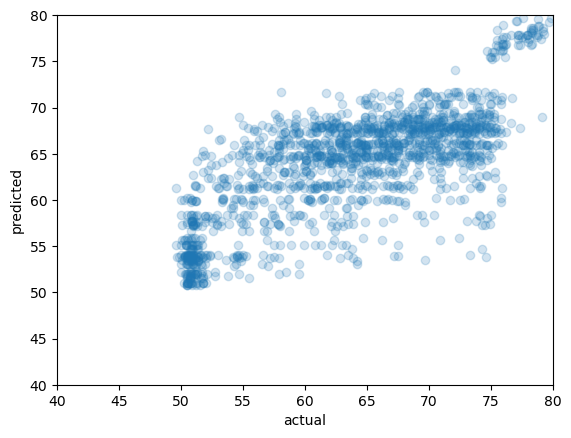

In [278]:
plt.scatter(y_train,regressor.predict(X_train), alpha=0.2)
plt.xlim([40,80])
plt.ylim([40,80])
plt.xlabel('actual')
plt.ylabel('predicted')

(40.0, 80.0)

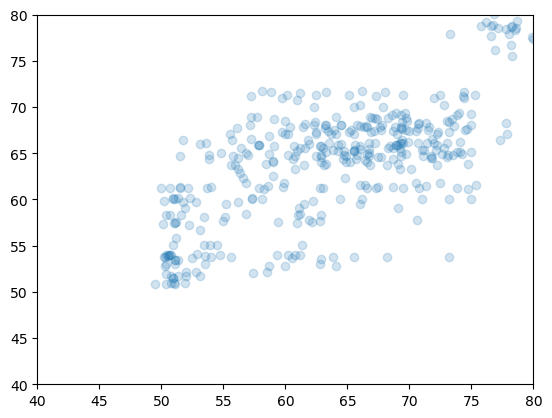

In [279]:
plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlim([40,80])
plt.ylim([40,80])

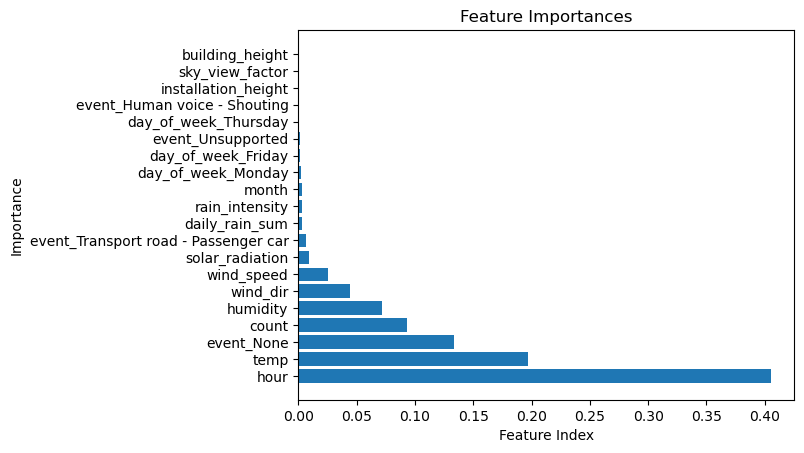

In [280]:
# model the location with their coordinates (so that the locations that are closer can be )
# # Get the feature importances
importances = regressor.feature_importances_
feature=X.columns
df_importances = pd.DataFrame({'feature': feature, 'importance': importances})

# Sort the DataFrame by feature importances in descending order
df_importances = df_importances.sort_values('importance', ascending=False).iloc[:20]

# Create a bar plot of feature importances
plt.barh(df_importances['feature'], df_importances['importance'])
plt.title('Feature Importances')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()

In [289]:
#df_importances.to_csv('feature_importance_sample.csv', index=None)